# Resampling ARD

One approach to achieving spatial-temporal consistency when using ARD is to resample the data to some standard (or regular) temporal interval before running anything.

Resampling, often referred to as compositing within remote sensing literature, is the process of grouping observations by time and reducing this group according to some criteria. One commonly used example of this is generating monthly "maximum NDVI" composites, often at an annual or monthly time intervals. Even more sophisticated approaches, like the "Best Available Pixel" approach from Wulder _et al_, can be described by this logic.

The resample operation can be considered to have the following parameters:

* Dimension (in this example, the time dimension)
* Interval
* Resampling criteria (usually a band or index)
* Reduction function (e.g., "max" or "min")

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import toolz
import xarray as xr

import ccd

plt.style.use('ggplot')

## Load data

In [2]:
ard = xr.open_dataset('./h03v09_ard_example.nc')
ard

<xarray.Dataset>
Dimensions:  (time: 2916, x: 10, y: 10)
Coordinates:
  * y        (y) float64 1.935e+06 1.935e+06 1.935e+06 1.935e+06 1.935e+06 ...
  * x        (x) float64 -2.11e+06 -2.11e+06 -2.11e+06 -2.109e+06 -2.109e+06 ...
    crs      int32 ...
  * time     (time) datetime64[ns] 1982-11-15 1982-11-24 1982-12-01 ...
Data variables:
    blue     (time, y, x) float64 ...
    green    (time, y, x) float64 ...
    red      (time, y, x) float64 ...
    nir      (time, y, x) float64 ...
    swir1    (time, y, x) float64 ...
    swir2    (time, y, x) float64 ...
    bt       (time, y, x) float64 ...
    cfmask   (time, y, x) float64 ...
Attributes:
    crs:          +datum=WGS84 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +...
    crs_wkt:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID[...
    Conventions:  CF-1.6
    spatial_ref:  PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID[...

Select a pixel to use as an example.

In [3]:
# Select
pix = ard.isel(x=0, y=0)

# Mask according to CFmask
land_water = np.array([0, 1])
pix = pix.where(np.in1d(pix['cfmask'], land_water))

# Create "ordinal" date for later
pix['ordinal'] = pix.get_index('time').map(lambda t: t.toordinal())

/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


## Resample

To resample, we can use [`xarray.DataArray.resample`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html#xarray.DataArray.resample) (see also [`pandas.DataFrame.resample`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)). See the [xarray guide on time series operations](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) for more information.

However, we need to add a little more code ourselves to resample other bands/variables/etc by our desired criteria.

In [4]:
_RESAMPLE_BY_METHODS = ('min', 'max', 'first', 'last', 'median', )


def resample_by(dataset, var, freq, dim, how='max',
                keep_attrs=True, **resample_kwds):
    """ Resample all variables in Dataset based on one ``var``
    
    For example, one could resample all Landsat bands based on the
    maximum value in the ``ndvi`` variable.

    Parameters
    ----------
    dataset : xarray.Dataset
        Dataset containing variables to resample. Cannot resample any
        data containing string or object datatypes.
    var : str
        Variable name in ``dataset``
    freq : str
        Offset frequency that specifies the step-size along the resampled dimension.
        Should look like ``{N}{offset}`` where ``N`` is an (optional) integer multipler
        (default 1) and ``offset`` is any pandas date offset alias. The full list of
        offset aliases is documented in pandas [1]_.
    dim : str
        Dimension name to resample along (e.g., 'time')
    how : str or callable
        Resampling reduction method (e.g., 'mean'). The method must not alter data from
        ``dataset``, so only operations like ``first`` or ``max`` are supported.
    keep_attrs : bool, optional
        If True, the object's attributes (`attrs`) will be copied from the original
        object to the new one.
    resample_kwds
        Keyword options to pass to :py:meth:`xarray.Dataset.resample`

    Returns
    -------
    xarray.Dataset
        Resampled dataset, resampled according to ``var``

    Raises
    ------
    ValueError
        Raised when using an unsupported resampling method
    TypeError
        Raised if any dataset variables are string/bytes/object datatype

    References
    ----------
    .. [1] http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    """
    # Implementation note:
    # xarray's "argmin" and "argmax" doesn't work with more than one dimension
    # See https://github.com/pydata/xarray/issues/1388
    # 
    # There should be  faster way than resampling and masking and resampling again,
    # but will need to wait on some work within `xarray`
    if how not in _RESAMPLE_BY_METHODS:
        raise ValueError("Cannot resample by '{0}'. Please choose from: {1}"
                         .format(how, ', '.join(_RESAMPLE_BY_METHODS)))

    # Without the ability to select based on argmin/argmax we need to use a
    # workaround (masking the arrays), but this doesn't work on string data
    is_str = [dv for dv in dataset.data_vars if
              dataset[dv].dtype.type in (np.str_, np.bytes_, np.object_)]
    if is_str:
        raise TypeError('Cannot use `resample_by` with string or object '
                        'datatypes (as used by {var})'
                        .format(var=', '.join(['"%s"' % dv for dv in is_str])))

    # Resample by criterion variable
    kwds_re = toolz.merge({dim: freq}, resample_kwds)
    var_re = getattr(dataset[[var]].resample(**kwds_re), how)()

    # Now that we know what observations have been selected by the reduction,
    # reindex the resampled data to look like the original dataset
    var_reidx = var_re.reindex_like(dataset, method='ffill')

    # Find where identical, and mask the rest so that it can be ignored when we resample
    mask = (dataset[[var]] == var_reidx[[var]])[var]
    ds_masked = dataset.where(mask)
    
    # Ideally we want to use 'first' instead of 'max', but it's not implemented on dask arrays
    return ds_masked.resample(**kwds_re).max()

In this example, we define the ratio of the NIR to the blue, which is pretty good at eliminating clouds and cloud shadows.

In [5]:
pix['sr_nir_blue'] = pix['nir'] / pix['blue']

In [6]:
criterion = 'sr_nir_blue'

resample_freq = '16D'
resample_dim = 'time'
resample_reduce = 'max'

pix_re = resample_by(pix, criterion, resample_freq, resample_dim, how=resample_reduce)

/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger

## Visualize

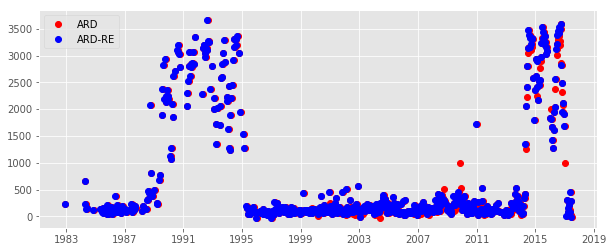

In [7]:
%matplotlib inline

plot_var = 'swir1'

fig, ax = plt.subplots(figsize=(10, 4))

x = pix.get_index('time').to_pydatetime()
ax.plot(x, pix[plot_var], 'ro', label='ARD')

x_re = pix_re.get_index('time').to_pydatetime()
ax.plot(x_re, pix_re[plot_var], 'bo', label='ARD-RE')

ax.legend()

As you can see, resampling to 16 day frequency in this example data only affects observations post-1999 when there were two satellites acquiring data.

This resampling would also help achieve consistency for pixels that are in the overlap across Landsat orbit paths. By carefully picking our selection criterion variable, we can help remove some amount of noise due to clouds or cloud shadows. The resampling process can also reduce the impact of BRDF effects by consistently selecting data from one view angle over another.

## CCD

With the data resampled, we can compare the performance in CCD.

In [8]:
# The example data CFmask data have been converted to old Fmask format
params = {
    'QA_BITPACKED': False,
    'QA_FILL': 255,
    'QA_CLEAR': 0,
    'QA_WATER': 1,
    'QA_SHADOW': 2,
    'QA_SNOW': 3,
    'QA_CLOUD': 4
}

ccd_vars = ('ordinal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'bt', 'cfmask')

In [9]:
detect = ccd.detect(*(pix[v] for v in ccd_vars), params=params)

/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/ccd/models/robust_fit.py:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta, _, _, _ = numpy.linalg.lstsq(Xw, yw)


In [10]:
detect_re = ccd.detect(*(pix_re[v] for v in ccd_vars), params=params)

/home/ceholden/conda/envs/resample/lib/python3.6/site-packages/ccd/models/robust_fit.py:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta, _, _, _ = numpy.linalg.lstsq(Xw, yw)


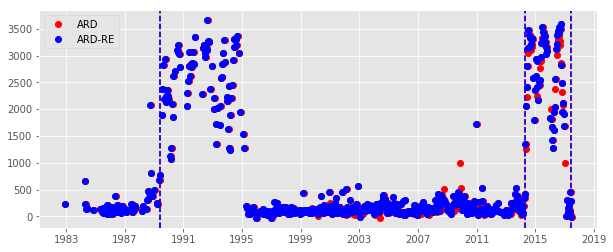

In [11]:
%matplotlib inline

plot_var = 'swir1'

fig, ax = plt.subplots(figsize=(10, 4))

# Original data
x = pix.get_index('time').to_pydatetime()
ax.plot(x, pix[plot_var], 'ro', label='ARD')

for model in detect['change_models']:
    break_day = dt.datetime.fromordinal(model['break_day'])
    ax.axvline(break_day, c='r', ls='--')

# Resampled data
x_re = pix_re.get_index('time').to_pydatetime()
ax.plot(x_re, pix_re[plot_var], 'bo', label='ARD-RE')

for model in detect_re['change_models']:
    break_day = dt.datetime.fromordinal(model['break_day'])
    ax.axvline(break_day, c='b', ls='--')

ax.legend()

In this example, resampling the data did not change the result of the CCD break detection modeling.